<a href="https://colab.research.google.com/github/aamirattara/Quantitative-Finance/blob/main/Quantitative_Portfolio_Strategy_using_Machine%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[***                    6%                       ]  3 of 51 completed

[*********************100%***********************]  51 of 51 completed
[*********************100%***********************]  1 of 1 completed



=== Rolling Backtest Results (2020–2025) ===
Portfolio Cumulative Return: 1891.02%
Benchmark Cumulative Return: 90.33%

Quarterly Performance (last 10 quarters):
            Portfolio  Benchmark  Excess Return
Date                                           
2023-06-30   0.287093   0.096287       0.190807
2023-09-30   0.035500  -0.033858       0.069358
2023-12-31   0.000000   0.000000       0.000000
2024-03-31   0.000000   0.000000       0.000000
2024-06-30   0.000000   0.000000       0.000000
2024-09-30   0.002770   0.004237      -0.001466
2024-12-31   0.267368   0.031718       0.235650
2025-03-31   0.077782  -0.040584       0.118366
2025-06-30   0.374372   0.123106       0.251266
2025-09-30   0.231407   0.064428       0.166980

Top Contributors (last 10 quarters):
           Top Stock  Contribution %
Quarter                             
2021-12-31       CAT        0.021619
2022-03-31       MRK        0.028872
2022-06-30      NFLX        0.093687
2022-09-30       MRK        0.071890
2

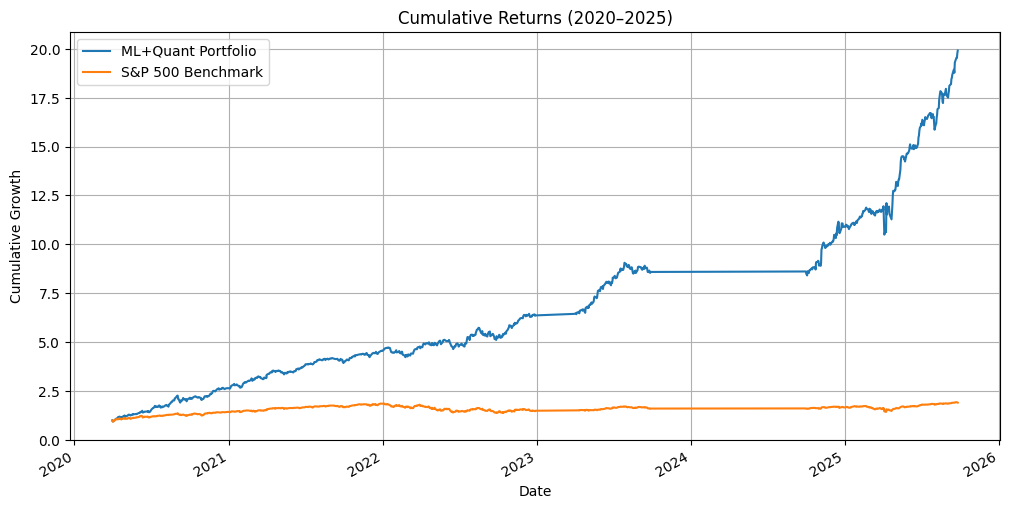

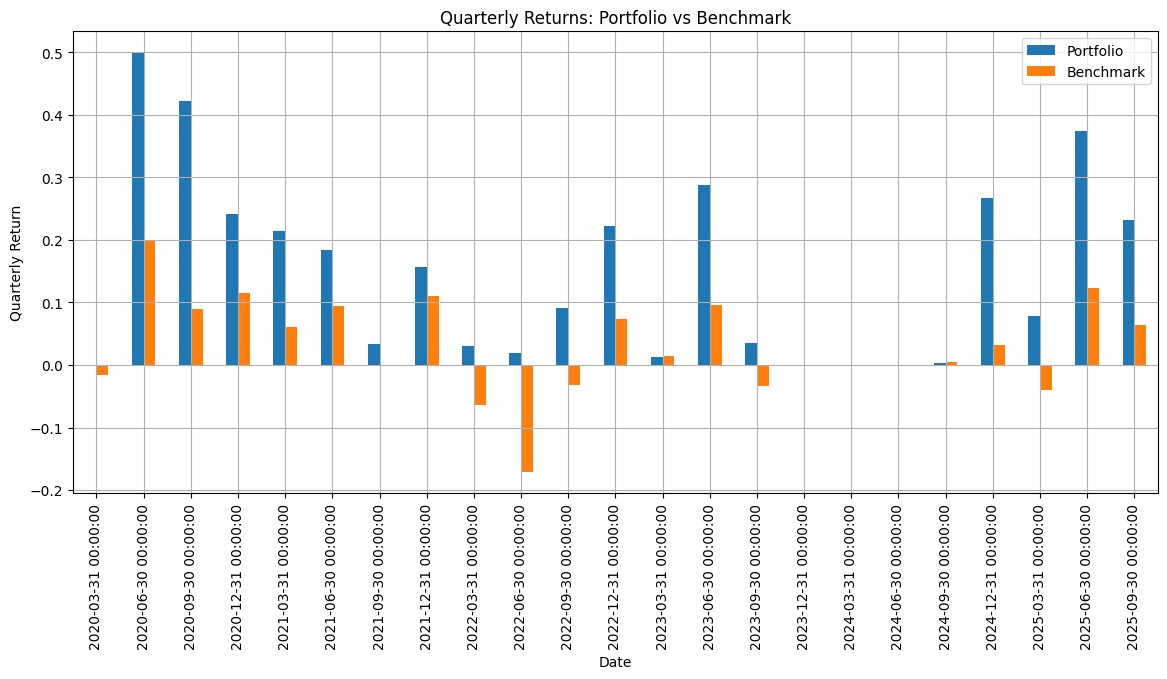

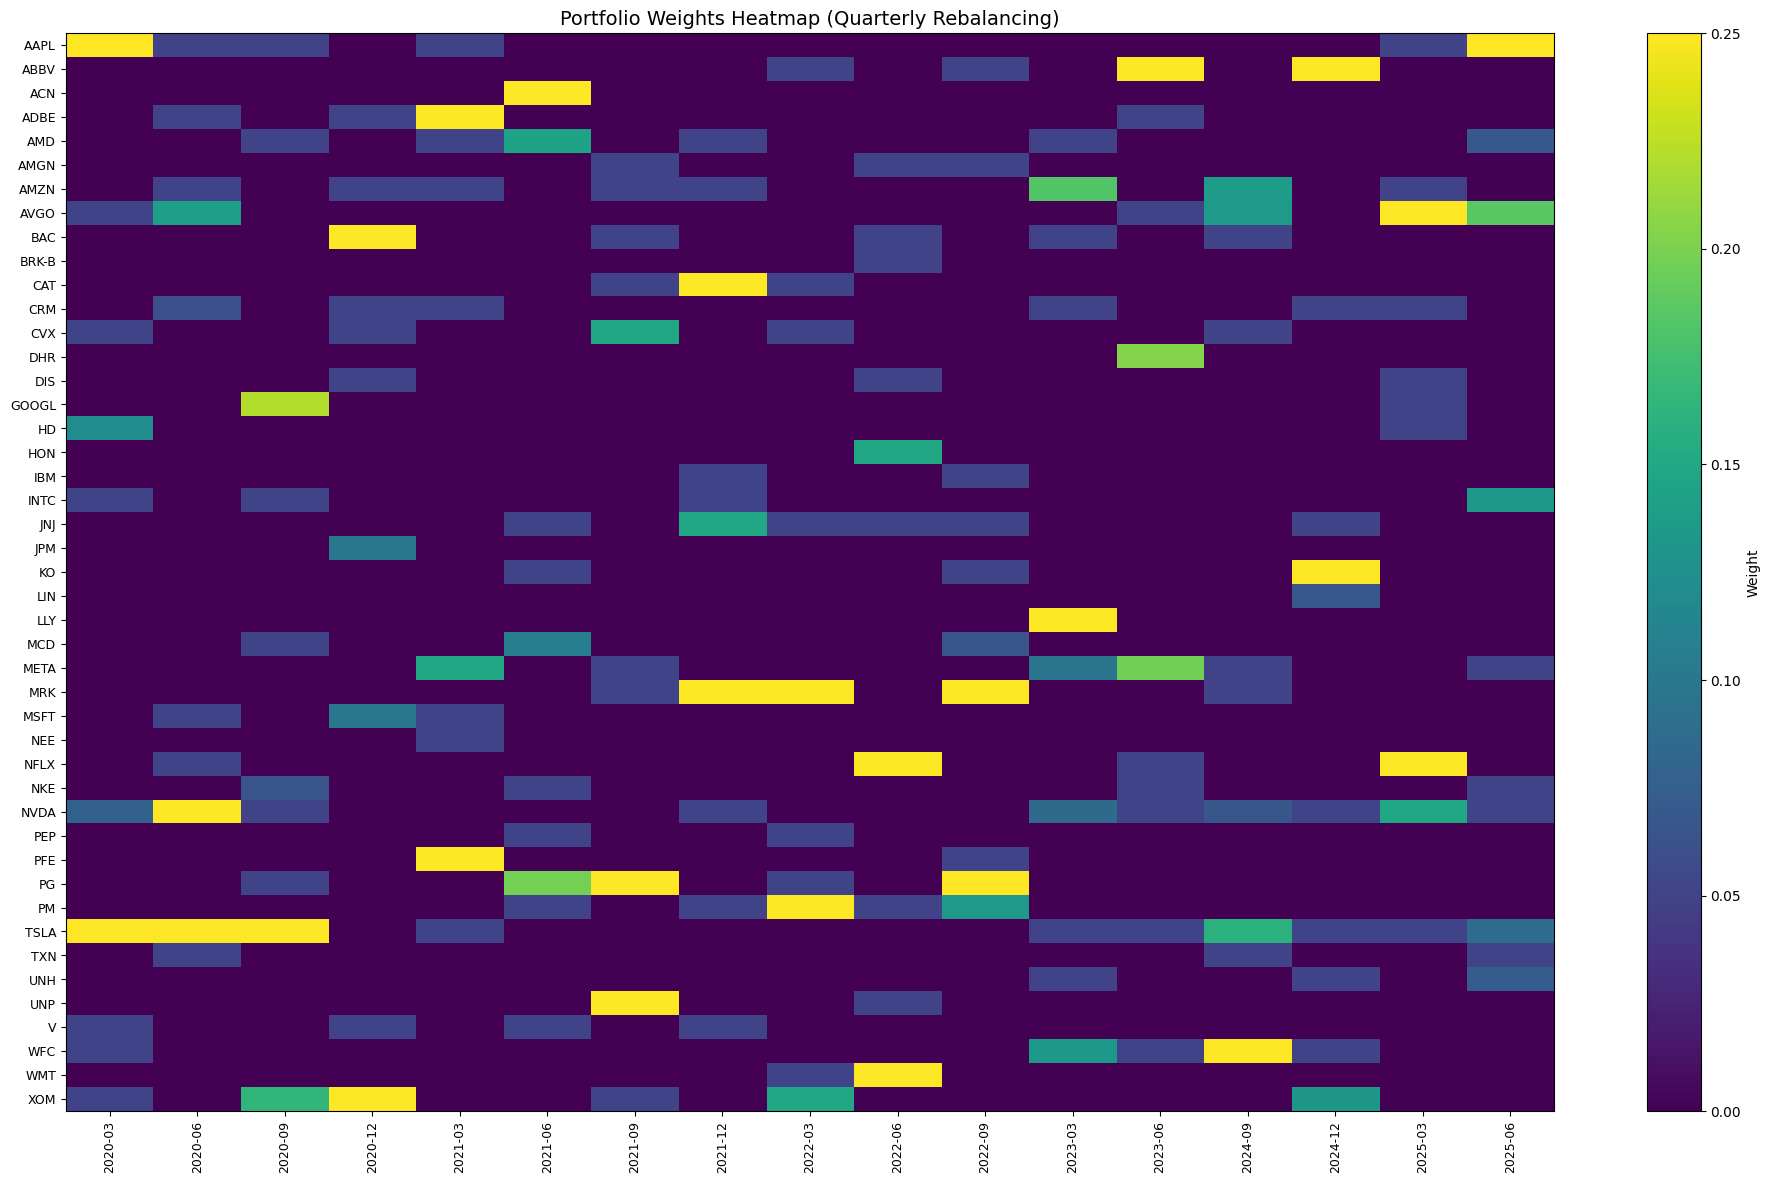

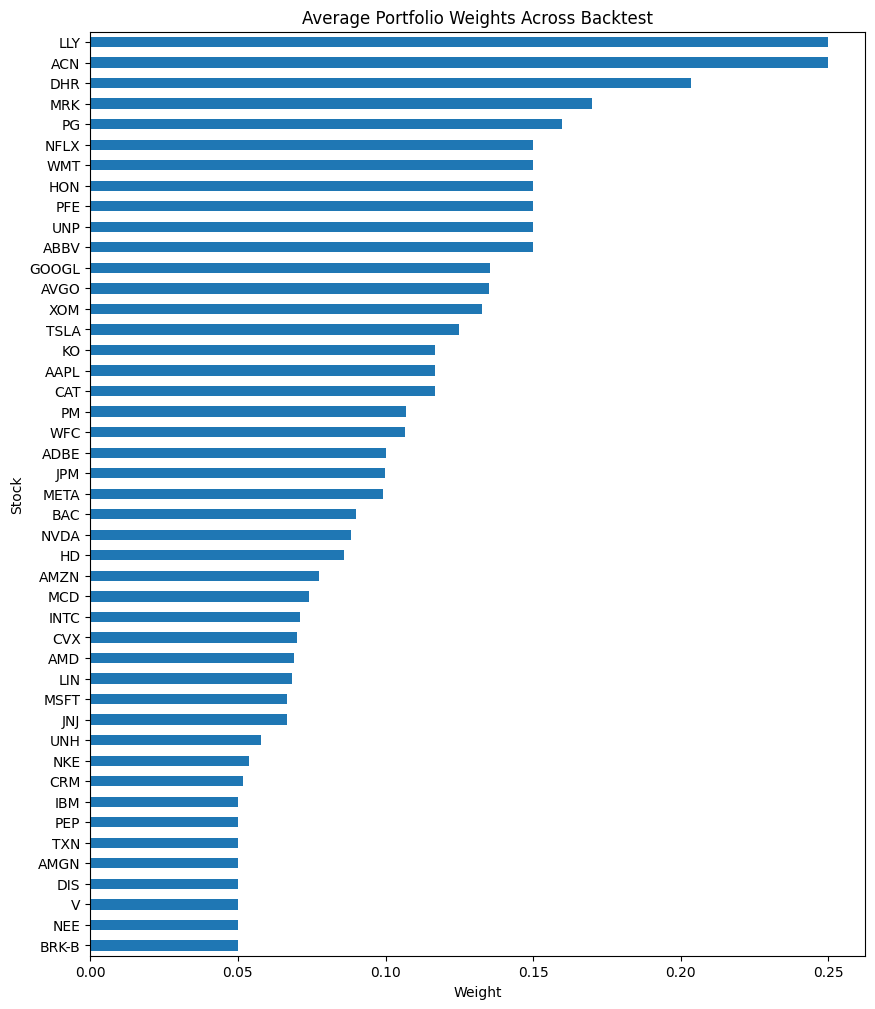

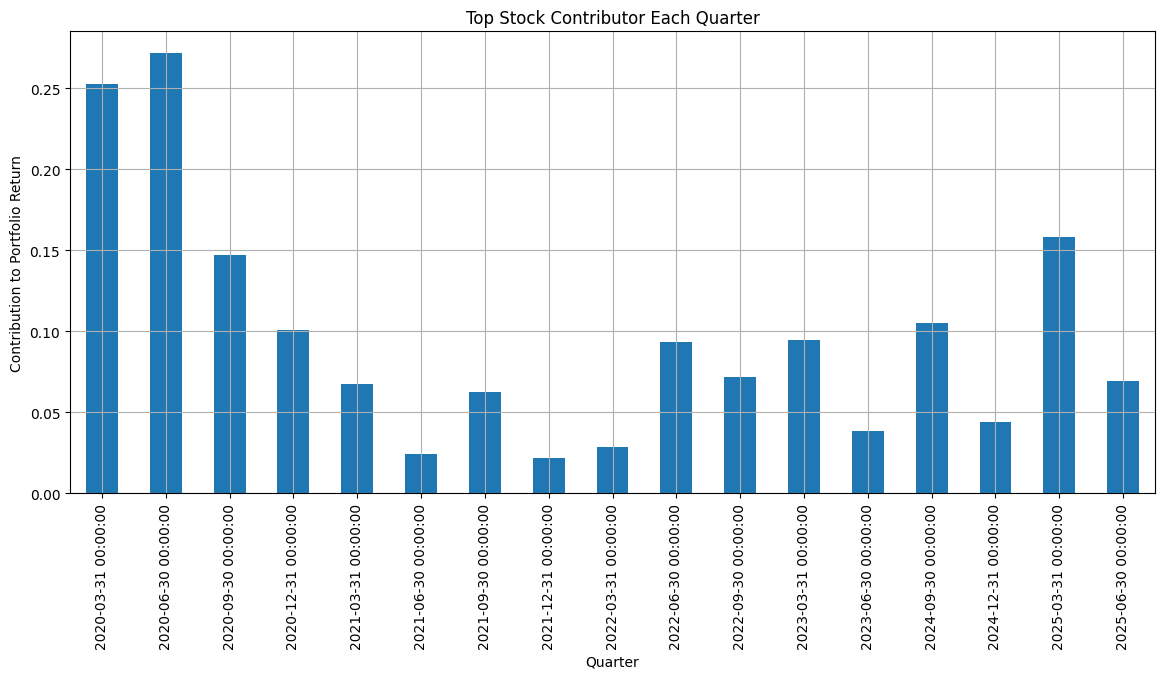

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy.optimize import minimize
import warnings, time
warnings.filterwarnings("ignore")

# ---------------- PARAMETERS ----------------
tickers = [
    "AAPL","MSFT","GOOGL","AMZN","NVDA","META","TSLA","BRK-B","JNJ","JPM",
    "V","UNH","PG","XOM","MA","HD","LLY","PEP","KO","AVGO","BAC","ABBV","MRK",
    "CVX","COST","WMT","ADBE","PFE","DIS","CSCO","MCD","NFLX","ACN","TMO","ABT",
    "CRM","WFC","LIN","TXN","DHR","NKE","NEE","INTC","AMD","PM","HON","AMGN","UNP","ORCL","IBM","CAT"
]
top_n = 10
benchmark = "^GSPC"
start, end = "2018-01-01", "2025-09-26"
risk_free_rate = 0.03
lookback = 756  # 3 years

# ---------------- DOWNLOAD DATA ----------------
print("Downloading stock & benchmark data...")
stock_data = yf.download(tickers, start=start, end=end, auto_adjust=True)
bench_data = yf.download(benchmark, start=start, end=end, auto_adjust=True)

#Ensure Consistency in Column Naming - Sometimes auto_adjust=True still puts data under 'Close' column. This ensures we uniformly refer to it as 'Adj Close'.
if 'Close' in stock_data.columns:
    stock_data = stock_data.rename(columns={'Close': 'Adj Close'})
if 'Close' in bench_data.columns:
    bench_data = bench_data.rename(columns={'Close': 'Adj Close'})

#Select Just the Prices You Need
stock_data = stock_data['Adj Close']
bench_data = bench_data['Adj Close']

# Compute returns
returns = stock_data.pct_change().dropna()
bench_returns = bench_data.pct_change().dropna()
returns[benchmark] = bench_returns

# ---------------- FEATURE ENGINEERING ----------------
def build_features(returns, tickers, benchmark):
    features, labels = {}, {}
    for t in tickers:
        df = pd.DataFrame(index=returns.index)
        df["1M_ret"] = returns[t].rolling(21).mean()
        df["3M_ret"] = returns[t].rolling(63).mean()
        df["6M_ret"] = returns[t].rolling(126).mean()
        df["Vol"]    = returns[t].rolling(63).std() * np.sqrt(252)
        df["Sharpe"] = df["3M_ret"] / df["Vol"]
        df["Beta"]   = returns[t].rolling(63).cov(returns[benchmark]) / returns[benchmark].rolling(63).var()

        # Target: outperform benchmark next 3 months
        future_ret = returns[t].rolling(63).mean().shift(-63)
        bench_ret  = returns[benchmark].rolling(63).mean().shift(-63)
        df["Target"] = (future_ret > bench_ret).astype(int)

        df = df.dropna()
        if not df.empty:
            features[t] = df.drop("Target", axis=1)
            labels[t] = df["Target"]
    return features, labels

features, labels = build_features(returns, tickers, benchmark)

# ---------------- PORTFOLIO OPTIMIZATION ----------------
def neg_sharpe(weights, mean_returns, cov_matrix, risk_free=risk_free_rate):
    port_ret = np.dot(weights, mean_returns) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return -(port_ret - risk_free) / port_vol

def optimize_portfolio(sel_returns, min_w=0.05, max_w=0.25):
    mean_returns = sel_returns.mean()
    cov_matrix   = sel_returns.cov()
    num_assets   = len(mean_returns)
    constraints = ({'type':'eq','fun': lambda x: np.sum(x) - 1})
    bounds = tuple((min_w, max_w) for _ in range(num_assets))
    init_guess = num_assets * [1./num_assets]
    result = minimize(neg_sharpe, init_guess,
                      args=(mean_returns, cov_matrix),
                      method="SLSQP", bounds=bounds, constraints=constraints)
    return result.x if result.success else init_guess

# ---------------- ROLLING QUARTERLY BACKTEST ----------------
portfolio_returns = []
benchmark_returns = []
selection_log = []
top_contributors = []  # NEW

first_test = "2020-01-01"

start_time = time.time()

for rebalance_date in pd.date_range(first_test, end, freq="Q"):
    train_feats, train_labels = [], []

    # rolling training set
    for t in features:
        df = pd.concat([features[t].loc[:rebalance_date], labels[t].loc[:rebalance_date]], axis=1).dropna()
        df = df.iloc[-lookback:]
        if df.empty: continue
        X_t = df.drop("Target", axis=1).to_numpy()
        y_t = df["Target"].to_numpy()
        train_feats.append(X_t)
        train_labels.append(y_t)

    if not train_feats: continue
    X_train = np.vstack(train_feats)
    y_train = np.hstack(train_labels)

    # train model
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    # predict probability
    latest_probs = {}
    for t in tickers:
        try:
            row = features[t].loc[rebalance_date].values.reshape(1, -1)
            prob = model.predict_proba(row)[0,1]
            latest_probs[t] = prob
        except:
            continue

    # select top N
    top_stocks = sorted(latest_probs, key=latest_probs.get, reverse=True)[:top_n]
    sel_returns = returns[top_stocks].loc[rebalance_date:].iloc[:63]
    if sel_returns.empty: continue

    # optimize weights
    weights = optimize_portfolio(sel_returns)

    # log selection
    log_entry = pd.DataFrame({
        "Rebalance Date": rebalance_date,
        "Stock": top_stocks,
        "Weight": weights
    })
    selection_log.append(log_entry)

    # portfolio returns
    port_ret = (sel_returns * weights).sum(axis=1)
    portfolio_returns.append(port_ret)
    benchmark_returns.append(returns[benchmark].loc[rebalance_date:].iloc[:63])

    # --- Top contributor calc ---
    contrib = (sel_returns + 1).prod() - 1  # stock return over quarter
    contrib = contrib * weights             # weighted contribution
    top_stock = contrib.idxmax()
    top_contributors.append({
        "Quarter": rebalance_date,
        "Top Stock": top_stock,
        "Contribution %": contrib[top_stock]
    })

# ---------------- RESULTS ----------------
portfolio_returns = pd.concat(portfolio_returns)
benchmark_returns = pd.concat(benchmark_returns)
selection_log = pd.concat(selection_log)
top_contributors = pd.DataFrame(top_contributors).set_index("Quarter")

cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_benchmark = (1 + benchmark_returns).cumprod()

# Quarterly performance
quarterly_perf = pd.DataFrame({
    "Portfolio": portfolio_returns.resample("Q").apply(lambda x: (1+x).prod()-1),
    "Benchmark": benchmark_returns.resample("Q").apply(lambda x: (1+x).prod()-1)
})
quarterly_perf["Excess Return"] = quarterly_perf["Portfolio"] - quarterly_perf["Benchmark"]

# ---------------- PRINT SUMMARY ----------------
print("\n=== Rolling Backtest Results (2020–2025) ===")
print(f"Portfolio Cumulative Return: {cumulative_portfolio.iloc[-1]-1:.2%}")
print(f"Benchmark Cumulative Return: {cumulative_benchmark.iloc[-1]-1:.2%}")
print("\nQuarterly Performance (last 10 quarters):")
print(quarterly_perf.tail(10))
print("\nTop Contributors (last 10 quarters):")
print(top_contributors.tail(10))

# ---------------- PLOTS ----------------
# 1. Cumulative returns
plt.figure(figsize=(12,6))
cumulative_portfolio.plot(label="ML+Quant Portfolio")
cumulative_benchmark.plot(label="S&P 500 Benchmark")
plt.title("Cumulative Returns (2020–2025)")
plt.ylabel("Cumulative Growth")
plt.legend()
plt.grid(True)
plt.show()

# 2. Quarterly returns comparison
quarterly_perf[["Portfolio","Benchmark"]].plot(kind="bar", figsize=(14,6))
plt.title("Quarterly Returns: Portfolio vs Benchmark")
plt.ylabel("Quarterly Return")
plt.grid(True)
plt.show()

# 3. Heatmap of allocations
pivot_log = selection_log.pivot(index="Rebalance Date", columns="Stock", values="Weight").fillna(0)
plt.figure(figsize=(24,14))
plt.imshow(pivot_log.T, aspect="auto", cmap="viridis")
plt.colorbar(label="Weight")
plt.yticks(range(len(pivot_log.columns)), pivot_log.columns, fontsize=9)
plt.xticks(range(len(pivot_log.index)), pivot_log.index.strftime("%Y-%m"), rotation=90, fontsize=9)
plt.title("Portfolio Weights Heatmap (Quarterly Rebalancing)", fontsize=14)
plt.show()

# 4. Average stock weights
selection_log.groupby("Stock")["Weight"].mean().sort_values().plot(kind="barh", figsize=(10,12))
plt.title("Average Portfolio Weights Across Backtest")
plt.xlabel("Weight")
plt.show()

# 5. Top contributors per quarter
top_contributors["Contribution %"].plot(kind="bar", figsize=(14,6))
plt.title("Top Stock Contributor Each Quarter")
plt.ylabel("Contribution to Portfolio Return")
plt.grid(True)
plt.show()
